# Transfer learning
- 좋은 모델의 지식을 내 모델에 사용할 수 있는 테크닉
- 데이터셋이 부족한 상황에 적합
- GPU 자원이 부족하여 많은 학습이 어려운 상황에 적합

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by Jin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import copy

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)

test_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)

In [3]:
print(f"# of train data: {len(train_data)}")
print(f"# of test data: {len(test_data)}")

# of train data: 244
# of test data: 153


#### Visualize images

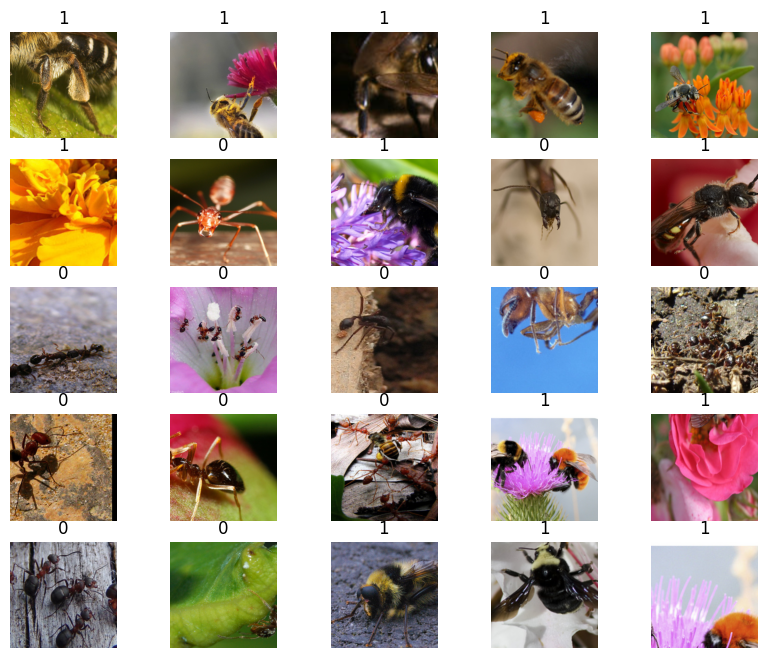

Data shape: (224, 224, 3)


In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5,5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()
print('Data shape:', img.shape)

#### Train a shallow model from scratch

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # TODO
        # Channel dimension
        # Hint: image has 3 RGB channel
        # Hint: output has 2 labels (0: ant, 1: bee)
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels= 3,  # TODO
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 2 classes
        # 1/4 resolution from the original image due to two times of maxpool
        self.out = nn.Linear(32 * 56 * 56, 2)  # TODO
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output   # return x for visualization

#### Set device!

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Use device {device}")

Use device cuda:0


In [11]:
cnn = CNN().to(device)
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [12]:
import time
import copy

# Train the model
num_epochs = 10 

cnn_best = None
acc_best = 0

start = time.time()
for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0

    cnn.train()
    for i, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Inference
        output = cnn(images)
        _, preds = torch.max(output, 1)

        # Calculate loss
        loss = loss_func(output, labels)

        # clear gradients for this training step   
        optimizer.zero_grad()           

        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()  

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)


    # 통계값
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)
    print ('Epoch [{}/{}], Train -> Loss: {:.4f}, Acc: {:.4f}' 
                   .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))
    
    
    running_loss = 0.0
    running_corrects = 0
    cnn.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_test):
            images = images.to(device)
            labels = labels.to(device)
            
            # Inference
            output = cnn(images)      
            _, preds = torch.max(output, 1)     
    
            # Calculate loss
            loss = loss_func(output, labels)
    
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # 통계값
        epoch_loss = running_loss / len(test_data)
        epoch_acc = running_corrects.double() / len(test_data)
    
        print ('Epoch [{}/{}], Valid -> Loss: {:.4f}, Acc: {:.4f}' 
                   .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))

        # Fine the best model
        if acc_best < epoch_acc:
            acc_best = epoch_acc
            cnn_best = copy.deepcopy(cnn)
    
elapsed_time = time.time()-start
print(f"elapsed time : {elapsed_time} sec")

/home/piai/anaconda3/envs/cv_2025/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Train -> Loss: 0.7457, Acc: 0.6025
Epoch [1/10], Valid -> Loss: 0.7030, Acc: 0.6144
Epoch [2/10], Train -> Loss: 0.7117, Acc: 0.5820
Epoch [2/10], Valid -> Loss: 0.7091, Acc: 0.5359
Epoch [3/10], Train -> Loss: 0.6710, Acc: 0.6189
Epoch [3/10], Valid -> Loss: 0.6808, Acc: 0.5425
Epoch [4/10], Train -> Loss: 0.6527, Acc: 0.6270
Epoch [4/10], Valid -> Loss: 0.6762, Acc: 0.6013
Epoch [5/10], Train -> Loss: 0.6701, Acc: 0.6066
Epoch [5/10], Valid -> Loss: 0.6423, Acc: 0.6536
Epoch [6/10], Train -> Loss: 0.6108, Acc: 0.6803
Epoch [6/10], Valid -> Loss: 0.6133, Acc: 0.6732
Epoch [7/10], Train -> Loss: 0.6440, Acc: 0.6025
Epoch [7/10], Valid -> Loss: 0.6837, Acc: 0.5163
Epoch [8/10], Train -> Loss: 0.6456, Acc: 0.5984
Epoch [8/10], Valid -> Loss: 0.7115, Acc: 0.5490
Epoch [9/10], Train -> Loss: 0.6159, Acc: 0.6639
Epoch [9/10], Valid -> Loss: 0.6890, Acc: 0.5948
Epoch [10/10], Train -> Loss: 0.5743, Acc: 0.6680
Epoch [10/10], Valid -> Loss: 0.7673, Acc: 0.6013
elapsed time : 14.

In [13]:
cnn_best.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        
        # Inference
        test_output = cnn_best(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 67.32 Percent


## Use transfer learning
- Learn about 'fine tuning' technique
- Freeze pretrained weight
- Tip1: Train only classifier layer
- Tip2: Use small learning rate!

In [14]:
from torchvision.models import resnet18

model_ft = resnet18(pretrained=True)

print(model_ft)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/piai/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Freeze layers except for final output layer
# requires_grad=False로 설정 시, 해당 layer는 optimizer에 의해 update되지 않음
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features # 512
model_ft.fc = nn.Linear(num_ftrs, 2)

# Replace the output layer
# TODO
# 새로 생성한 Linear layer의 output dimension은?
# Hint: 현재 모델이 추정해야 하는 데이터셋의 class label 개수
# 참고: 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 로 설정됨
model_ft.fc = nn.Linear(num_ftrs, 2) # TODO

## Find your own learning rate
- Learning rate (lr)을 조절해 가면서 85% 이상의 accuracy를 달성해 보세요!

In [22]:
model_ft = model_ft.to(device)
loss_func = nn.CrossEntropyLoss()

# TODO
# Set your own learning rate!
# Hint: fine-tuning 시 learning rate는 어느 정도 작은 수치가 좋음.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # TODO

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
import time
import copy

# Train the model
num_epochs = 10 

model_ft_best = None
acc_best = 0

start = time.time()
for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0

    model_ft.train()
    for i, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Inference
        output = model_ft(images)
        _, preds = torch.max(output, 1)

        # Calculate loss
        loss = loss_func(output, labels)

        # clear gradients for this training step   
        optimizer_ft.zero_grad()           

        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer_ft.step()  

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # apply learning rate scheduler
        exp_lr_scheduler.step()

    # 통계값
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)
    print ('Epoch [{}/{}], Train -> Loss: {:.4f}, Acc: {:.4f}' 
                   .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))
    
    
    running_loss = 0.0
    running_corrects = 0
    model_ft.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_test):
            images = images.to(device)
            labels = labels.to(device)
            
            # Inference
            output = model_ft(images)      
            _, preds = torch.max(output, 1)     
    
            # Calculate loss
            loss = loss_func(output, labels)
    
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # 통계값
        epoch_loss = running_loss / len(test_data)
        epoch_acc = running_corrects.double() / len(test_data)
    
        print ('Epoch [{}/{}], Valid -> Loss: {:.4f}, Acc: {:.4f}' 
                   .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))

        # Fine the best model
        if acc_best < epoch_acc:
            acc_best = epoch_acc
            model_ft_best = copy.deepcopy(model_ft)
    
elapsed_time = time.time()-start
print(f"elapsed time : {elapsed_time} sec")

Epoch [1/10], Train -> Loss: 0.6735, Acc: 0.6066
Epoch [1/10], Valid -> Loss: 0.6856, Acc: 0.5229
Epoch [2/10], Train -> Loss: 0.6538, Acc: 0.6230
Epoch [2/10], Valid -> Loss: 0.6869, Acc: 0.5556
Epoch [3/10], Train -> Loss: 0.6881, Acc: 0.5410
Epoch [3/10], Valid -> Loss: 0.7015, Acc: 0.4902
Epoch [4/10], Train -> Loss: 0.6653, Acc: 0.5820
Epoch [4/10], Valid -> Loss: 0.6976, Acc: 0.4967
Epoch [5/10], Train -> Loss: 0.6582, Acc: 0.5697
Epoch [5/10], Valid -> Loss: 0.6860, Acc: 0.5556
Epoch [6/10], Train -> Loss: 0.6684, Acc: 0.5738
Epoch [6/10], Valid -> Loss: 0.6772, Acc: 0.5686
Epoch [7/10], Train -> Loss: 0.6755, Acc: 0.5574
Epoch [7/10], Valid -> Loss: 0.6831, Acc: 0.5621
Epoch [8/10], Train -> Loss: 0.6747, Acc: 0.5492
Epoch [8/10], Valid -> Loss: 0.6875, Acc: 0.5359
Epoch [9/10], Train -> Loss: 0.6531, Acc: 0.6107
Epoch [9/10], Valid -> Loss: 0.6921, Acc: 0.5229
Epoch [10/10], Train -> Loss: 0.6849, Acc: 0.5328
Epoch [10/10], Valid -> Loss: 0.6893, Acc: 0.5556
elapsed time : 16.

In [24]:
model_ft_best.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        
        # Inference
        test_output = model_ft_best(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 56.86 Percent
